In [1]:
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler


In [34]:
import pyreadstat

# Load required columns
individual, meta = pyreadstat.read_dta("3_LASI_W1_Individual.dta", usecols=use_cols)
use_cols = ['hhid', 'prim_key', 'ht103', 'age', 'gender', 'ht219', 'depression_score', 'sleep_trouble', 'multimorbidity']


# Drop missing target values
df = individual.dropna(subset=['ht103']).copy()

# Map target variable to binary
df['fall_binary'] = df['ht103'].map({1: 1, 2: 0})


In [3]:
# Drop ID and target columns for X
X = df.drop(columns=['ht103', 'fall_binary', 'prim_key', 'hhid'])

# Encode categorical features
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

# Define target
y = df['fall_binary']


In [4]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


In [6]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [7]:
#  Best model
best_rf = grid_search.best_estimator_

In [28]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.64      0.59     18152
           1       0.57      0.47      0.52     18151

    accuracy                           0.56     36303
   macro avg       0.56      0.56      0.55     36303
weighted avg       0.56      0.56      0.55     36303


Confusion Matrix:
 [[11573  6579]
 [ 9563  8588]]


In [24]:

#  Print best hyperparameters
print("Best Parameters:", grid_search.best_params_)

#  Full classification report (includes accuracy)
from sklearn.metrics import accuracy_score
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Print Accuracy separately
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2%}")

#  Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.64      0.59     18152
           1       0.57      0.47      0.52     18151

    accuracy                           0.56     36303
   macro avg       0.56      0.56      0.55     36303
weighted avg       0.56      0.56      0.55     36303


Accuracy: 55.54%

Confusion Matrix:
 [[11573  6579]
 [ 9563  8588]]


In [9]:
# Fall prediction probability + report function
def predict_fall_probabilities(model, X_test, y_test, top_n=10):
    y_proba = model.predict_proba(X_test)
    results_df = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': model.predict(X_test),
        'Probability_Fall': y_proba[:, 1]
    }, index=X_test.index)

    print(f"\nTop {top_n} predicted cases with probabilities:\n")
    print(results_df.head(top_n))

    plt.figure(figsize=(8,5))
    plt.hist(results_df['Probability_Fall'], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Probability of Fall')
    plt.ylabel('Number of Individuals')
    plt.title('Distribution of Fall Probabilities')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return results_df


Top 20 predicted cases with probabilities:

        Actual  Predicted  Probability_Fall
102867       1          0          0.449008
102278       1          0          0.449008
42637        0          0          0.449008
82574        1          0          0.449008
112685       1          1          0.659877
4563         1          1          0.536494
37619        0          0          0.449008
34497        0          0          0.449008
21826        0          1          0.536494
42487        0          0          0.449008
101309       1          1          0.536494
79642        1          1          0.578511
14171        0          1          0.536494
7660         0          0          0.449008
37532        0          1          0.536494
16760        0          1          0.536494
120372       1          1          0.578511
3023         0          1          0.536494
84642        1          0          0.449008
85402        1          1          0.536494


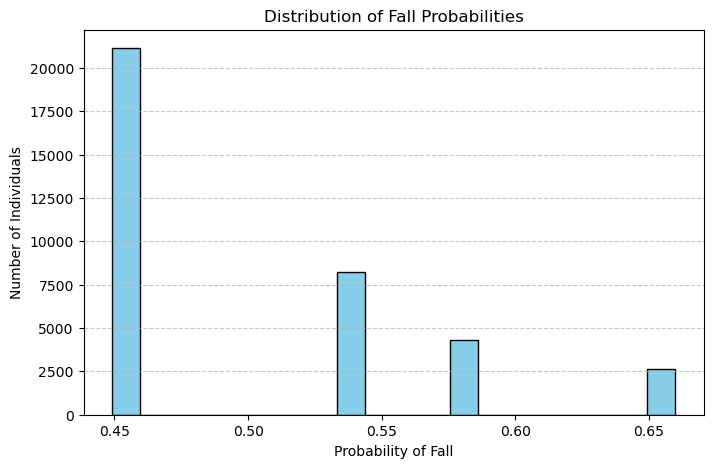

In [42]:
#  Run probability prediction
fall_predictions = predict_fall_probabilities(best_rf, X_test, y_test, top_n=20)

In [11]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

ht219    1.0
dtype: float64
